In [1]:
import os
import glob
import shutil
import numpy as np 
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
from scipy import signal
import random 
from tensorflow import keras 
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
import tensorflow as tf
from tensorflow.keras.utils import multi_gpu_model
from tensorflow.keras.layers import UpSampling1D,Input,Reshape,CuDNNLSTM,LeakyReLU,ZeroPadding1D,Conv1D,BatchNormalization,Activation,MaxPooling1D,Dropout,Dense,Flatten,Bidirectional,LSTM,GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,EarlyStopping,ReduceLROnPlateau
import itertools

/home/ubuntu/anaconda3/envs/jyh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/jyh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/anaconda3/envs/jyh/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/anaconda3/envs/jyh/lib/python3.6/site-pack

In [2]:
prep_path = '/home/ubuntu/Dataset/prep_path_pulse1/'
label_csv = '/home/ubuntu/Dataset/현황_간소화.xlsx'
model_path = '/home/ubuntu/Dataset/model/'
seed = 7

total_len = 194

def load_label():
    label_filename = label_csv
    label_df = pd.read_excel(label_filename,header=2).drop([0]) # remove first line(figure)
    label_df = label_df[['실험NO.','중증도\n5단계']]
    label_df.columns=['subjectnb','label']
    label_df.replace({'label':{'Normal':0,'Presymptomatic AD':0,'Prodroaml AD':1,'AD Dementia 초기 ':3,'AD Dementia 초기':3,'AD Dementia 중기 ':4,'AD Dementia중기 ':4,'MCI unlikely due to AD':5,'PET or CSF (x)':6}},inplace=True)
    label_df.set_index(['subjectnb'],inplace=True)
    
    return dict(label_df.label)


label_dict = load_label()

class Subject():
    def __init__(self,snum,label_dict):
        if type(snum) is int:
            self.snum = 'S{:03}'.format(snum)
        elif type(snum) is str:
            self.snum = snum
        self.path = prep_path+self.snum
        self.data_dict = dict()
        
        for i in range(1,5):
            self.data_dict['E{}'.format(i)] = os.listdir(self.path+'/E{}'.format(i))
            self.data_dict['E{}'.format(i)].sort()
        
        self.severity = label_dict[self.snum]
    def load_data(self,filename):
        data = np.load(filename)
        return data
    
    def get_snum(self):
        return self.snum
    def get_severity(self):
        return self.severity
    
    def get_filenames(self,enum):
        return self.data_dict['E{}'.format(enum)]
    
    def get_filenames_path(self,enum):
        res = []
        file_path = self.path+'/E{}'.format(enum)
        for filename in self.data_dict['E{}'.format(enum)] :
            res.append(file_path+'/'+filename)
        return res
    
    def get_data(self,enum):
        res = []
        filenames = self.get_filenames_path(enum)
        
        for filename in filenames:
            res.append(self.load_data(filename))
        
        return res
    
    def get_len(self):
        res = []
        for i in self.data_dict:
            res.append(len(self.data_dict[i]))
        
        return res
    
    def print_info(self):
        print('{} = severity : {}, '.format(self.snum,self.severity),end='')
        for i,num in enumerate(self.get_len()):
            print('E{} len: {} '.format(i+1,num),end = ',\t')
        print()

S_cnt =  [[] for x in range(7) ]

E_cnt = np.zeros(4,dtype=int)

for i in range(1,total_len+1):
    tmp = Subject(i,label_dict)
    tmp.print_info()
    S_cnt[tmp.get_severity()].append(tmp.get_snum()) 
    E_cnt += tmp.get_len()
    
    
    
    
    
print()
print('S total : ',)
for i,s in enumerate(S_cnt):
    print('E{} : {} '.format(i+1,len(s)),end = ',\t')
print()   
print('E total : ')
for i,e in enumerate(E_cnt):
    print('E{} : {} '.format(i+1,e),end = ',\t')

def subject_split(S_cnt,using_num=[0,1],seed = random.randint(1,100),print_list=False):
    train,val,test = [],[],[]
    
    for i in using_num:
        train_list,remain_list = train_test_split(S_cnt[i],test_size=0.3, random_state=seed)
        val_list,test_list = train_test_split(remain_list,test_size=0.7, random_state=seed)
        print('label {} split result = train : {} , val : {} , test : {} : '.format(i,len(train_list),len(val_list),len(test_list)))
        train.extend(train_list)
        val.extend(val_list)
        test.extend(test_list)
    
    train.sort()
    val.sort()
    test.sort()
    print('total split result = train : {} , val : {} , test : {}'.format(len(train),len(val),len(test)))
    
    if print_list:
        print('\ntrain_list\n', train)
        print('\nval_list\n', val)
        print('\ntest_list\n', test)
        
    return train,val,test





def preprocessing(train_list,val_list,test_list,e_num=1,is_scale=False,resampling_len = 224,drop_channel = []):
    X_train,y_train = [],[]
    X_val,y_val = [],[]
    X_test,y_test = [],[]
    
    
    label_dict = load_label()
    
    print('train_list data load')
    for i in train_list:
#         print(i)
        
        tmp = Subject(i,label_dict)
        label = tmp.get_severity()
        data = tmp.get_data(e_num)
        
        for j in data:
            tmp_x = np.zeros((224, 63)).astype(np.float32)
            for k in range(63):
                resample = signal.resample(j[:,k],resampling_len)
                tmp_x[:,k] = resample
                
                
                if is_scale:
                    
                    scaler = MinMaxScaler(feature_range=(-1,1))
                    tmp_x = scaler.fit_transform(tmp_x)
                
            
            
#             plt.figure(figsize=(15,15))
#             for k in range(63):
#                 plt.subplot(7,9,k+1)
#                 plt.plot(tmp_x[:,k])
#             return
            X_train.append(tmp_x)
            y_train.append(label)
        
    print('val_list data load')
    print(val_list)
    for i in val_list:
#         print(i)
        
        tmp = Subject(i,label_dict)
        label = tmp.get_severity()
        data = tmp.get_data(e_num)
        for j in data:
            tmp_x = np.zeros((224, 63)).astype(np.float32)
            for k in range(63):
#                 tmp_x[:,k] = signal.resample(j[:,k],resampling_len)
                resample = signal.resample(j[:,k],resampling_len)
                tmp_x[:,k] = resample
                
                
                if is_scale:
                    
                    scaler = MinMaxScaler(feature_range=(-1,1))
                    tmp_x = scaler.fit_transform(tmp_x)
                
            
                
                
            
            X_val.append(tmp_x)
            y_val.append(label)
            
    print('test_list data load')
    print(test_list)

    for i in test_list:
#         print(i)
        
        tmp = Subject(i,label_dict)
        label = tmp.get_severity()
        data = tmp.get_data(e_num)
        for j in data:
            tmp_x = np.zeros((224, 63)).astype(np.float32)
            for k in range(63):
                resample = signal.resample(j[:,k],resampling_len)
                tmp_x[:,k] = resample
                
                
                if is_scale:
                    
                    scaler = MinMaxScaler(feature_range=(-1,1))
                    tmp_x = scaler.fit_transform(tmp_x)
#                 tmp_x[:,k] = signal.resample(j[:,k],resampling_len)
                
#             plt.figure(figsize=(15,15))
#             for k in range(63):
#                 plt.subplot(7,9,k+1)
#                 plt.plot(tmp_x[:,k])
#             return
            X_test.append(tmp_x)
            y_test.append(label)
            
            
    enc = OneHotEncoder()
    
    X_train = np.array(X_train)
    
    y_train = np.reshape(y_train,(-1,1))
    y_train = enc.fit_transform(y_train).toarray()
    
    X_val = np.array(X_val)
    
    y_val = np.reshape(y_val,(-1,1))
    y_val = enc.fit_transform(y_val).toarray()
    
    X_test = np.array(X_test)
    
    y_test = np.reshape(y_test,(-1,1))
    y_test = enc.fit_transform(y_test).toarray()
    
    
    if len(drop_channel) == 0:
        return X_train,y_train,X_val,y_val,X_test,y_test
    else:
        using_channel = list()
        for i in range(9):
            if i not in drop_channel:
                using_channel+=list(range(i,63,9))
        using_channel.sort()
        return X_train[:,:,using_channel],y_train,X_val[:,:,using_channel],y_val,X_test[:,:,using_channel],y_test
        

S001 = severity : 0, E1 len: 4 ,	E2 len: 4 ,	E3 len: 8 ,	E4 len: 5 ,	
S002 = severity : 0, E1 len: 2 ,	E2 len: 4 ,	E3 len: 8 ,	E4 len: 0 ,	
S003 = severity : 0, E1 len: 2 ,	E2 len: 2 ,	E3 len: 6 ,	E4 len: 0 ,	
S004 = severity : 0, E1 len: 2 ,	E2 len: 4 ,	E3 len: 14 ,	E4 len: 0 ,	
S005 = severity : 0, E1 len: 2 ,	E2 len: 2 ,	E3 len: 9 ,	E4 len: 6 ,	
S006 = severity : 3, E1 len: 4 ,	E2 len: 2 ,	E3 len: 5 ,	E4 len: 6 ,	
S007 = severity : 1, E1 len: 2 ,	E2 len: 6 ,	E3 len: 6 ,	E4 len: 11 ,	
S008 = severity : 0, E1 len: 2 ,	E2 len: 2 ,	E3 len: 5 ,	E4 len: 4 ,	
S009 = severity : 0, E1 len: 2 ,	E2 len: 2 ,	E3 len: 7 ,	E4 len: 5 ,	
S010 = severity : 0, E1 len: 3 ,	E2 len: 3 ,	E3 len: 6 ,	E4 len: 6 ,	
S011 = severity : 0, E1 len: 2 ,	E2 len: 2 ,	E3 len: 5 ,	E4 len: 4 ,	
S012 = severity : 5, E1 len: 2 ,	E2 len: 2 ,	E3 len: 6 ,	E4 len: 5 ,	
S013 = severity : 5, E1 len: 2 ,	E2 len: 2 ,	E3 len: 8 ,	E4 len: 5 ,	
S014 = severity : 5, E1 len: 4 ,	E2 len: 4 ,	E3 len: 15 ,	E4 len: 11 ,	
S015 = severity 

In [45]:

# train_list,val_list,test_list = subject_split(S_cnt = S_cnt,using_num=[0,1] ,seed = 7,print_list=True)
# X_train,y_train,X_val,y_val,X_test,y_test = preprocessing(train_list,val_list,test_list,is_scale=True,e_num=3,drop_channel=[])

label 0 split result = train : 66 , val : 8 , test : 21 : 
label 1 split result = train : 48 , val : 6 , test : 15 : 
total split result = train : 114 , val : 14 , test : 36

train_list
 ['S001', 'S002', 'S004', 'S005', 'S007', 'S009', 'S010', 'S011', 'S017', 'S018', 'S023', 'S024', 'S027', 'S031', 'S032', 'S033', 'S034', 'S035', 'S037', 'S038', 'S039', 'S040', 'S041', 'S042', 'S043', 'S046', 'S048', 'S049', 'S050', 'S053', 'S054', 'S055', 'S057', 'S058', 'S061', 'S062', 'S065', 'S069', 'S075', 'S076', 'S077', 'S078', 'S079', 'S080', 'S081', 'S085', 'S086', 'S087', 'S088', 'S089', 'S090', 'S091', 'S092', 'S093', 'S096', 'S097', 'S099', 'S100', 'S101', 'S102', 'S105', 'S108', 'S110', 'S112', 'S116', 'S117', 'S118', 'S120', 'S121', 'S122', 'S123', 'S125', 'S126', 'S128', 'S129', 'S130', 'S131', 'S132', 'S133', 'S134', 'S135', 'S136', 'S137', 'S139', 'S140', 'S141', 'S143', 'S145', 'S146', 'S147', 'S148', 'S150', 'S151', 'S153', 'S155', 'S157', 'S158', 'S159', 'S160', 'S162', 'S164', 'S16

In [59]:
# X_train.shape, X_val.shape, X_test.shape,y_train.shape, y_val.shape, y_test.shape

In [60]:
def ae_model(input_shape = (224,63)):
    input_img = Input(shape=input_shape)  # 'channels_firtst'이미지 데이터 형식을 사용하는 경우 이를 적용

    
    
    
    x = Conv1D(128, 3, activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(8, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling1D(2, padding='same')(x)


    x = Conv1D(8, 3, activation='relu', padding='same')(encoded)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)
    x = Conv1D(128, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling1D(2)(x)
    decoded = Conv1D(input_shape[1], 1, padding='same')(x)

    autoencoder = Model(input_img, decoded)
#     autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
#     autoencoder.summary()
    
#     encoded_input = Input(shape=(encoding_dim,))
    
    encoder = Model(input_img, encoded)
#     decoder = Model(encoded_input,decoded)
    return autoencoder,encoder

In [61]:
# # test result visulization
# def test(model,weight_path,X_test,y_test):
#     model = model
#     model.load_weights(weigth_file)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()    
    

label 0 split result = train : 66 , val : 8 , test : 21 : 
label 1 split result = train : 48 , val : 6 , test : 15 : 
total split result = train : 114 , val : 14 , test : 36

train_list
 ['S001', 'S002', 'S003', 'S004', 'S005', 'S007', 'S009', 'S019', 'S021', 'S023', 'S024', 'S026', 'S027', 'S028', 'S029', 'S030', 'S032', 'S035', 'S036', 'S042', 'S043', 'S045', 'S046', 'S047', 'S048', 'S049', 'S051', 'S053', 'S054', 'S055', 'S057', 'S058', 'S059', 'S060', 'S061', 'S062', 'S063', 'S064', 'S068', 'S069', 'S070', 'S072', 'S075', 'S077', 'S078', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S087', 'S088', 'S090', 'S092', 'S094', 'S099', 'S101', 'S103', 'S108', 'S109', 'S110', 'S112', 'S113', 'S114', 'S115', 'S116', 'S117', 'S120', 'S122', 'S124', 'S125', 'S127', 'S128', 'S130', 'S131', 'S132', 'S133', 'S134', 'S135', 'S136', 'S137', 'S138', 'S139', 'S144', 'S145', 'S146', 'S148', 'S152', 'S153', 'S154', 'S155', 'S157', 'S158', 'S159', 'S160', 'S163', 'S164', 'S167', 'S168', 'S17

Epoch 11/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.9440
Epoch 00011: val_loss improved from 8.02297 to 8.01035, saving model to /home/ubuntu/Dataset/model/my_model10_03_17_50/Epoch_011_Val_8.010.hdf5
874/874 [==============================] - 1s 813us/step - loss: 7.9809 - val_loss: 8.0104
Epoch 12/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.9809
Epoch 00012: val_loss improved from 8.01035 to 8.00562, saving model to /home/ubuntu/Dataset/model/my_model10_03_17_50/Epoch_012_Val_8.006.hdf5
874/874 [==============================] - 1s 813us/step - loss: 7.9693 - val_loss: 8.0056
Epoch 13/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.9227
Epoch 00013: val_loss improved from 8.00562 to 7.98001, saving model to /home/ubuntu/Dataset/model/my_model10_03_17_50/Epoch_013_Val_7.980.hdf5
874/874 [==============================] - 1s 811us/step - loss: 7.9578 - val_loss: 7.9800
Epoch 14/10000
800/874 [==========================>.

874/874 [==============================] - 1s 821us/step - loss: 7.5605 - val_loss: 7.7161
Epoch 38/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.5517
Epoch 00038: val_loss improved from 7.71607 to 7.68291, saving model to /home/ubuntu/Dataset/model/my_model10_03_17_50/Epoch_038_Val_7.683.hdf5
874/874 [==============================] - 1s 817us/step - loss: 7.5173 - val_loss: 7.6829
Epoch 39/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.5128
Epoch 00039: val_loss improved from 7.68291 to 7.63100, saving model to /home/ubuntu/Dataset/model/my_model10_03_17_50/Epoch_039_Val_7.631.hdf5
874/874 [==============================] - 1s 823us/step - loss: 7.4818 - val_loss: 7.6310
Epoch 40/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.4026
Epoch 00040: val_loss improved from 7.63100 to 7.61409, saving model to /home/ubuntu/Dataset/model/my_model10_03_17_50/Epoch_040_Val_7.614.hdf5
874/874 [==============================] - 1s 808us/

800/874 [==========================>...] - ETA: 0s - loss: 7.1953
Epoch 00065: val_loss improved from 7.37884 to 7.37549, saving model to /home/ubuntu/Dataset/model/my_model10_03_17_50/Epoch_065_Val_7.375.hdf5
874/874 [==============================] - 1s 820us/step - loss: 7.1965 - val_loss: 7.3755
Epoch 66/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.1763
Epoch 00066: val_loss improved from 7.37549 to 7.36820, saving model to /home/ubuntu/Dataset/model/my_model10_03_17_50/Epoch_066_Val_7.368.hdf5
874/874 [==============================] - 1s 816us/step - loss: 7.1952 - val_loss: 7.3682
Epoch 67/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.1833
Epoch 00067: val_loss did not improve from 7.36820
874/874 [==============================] - 1s 715us/step - loss: 7.1933 - val_loss: 7.3706
Epoch 68/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.2001
Epoch 00068: val_loss did not improve from 7.36820
874/874 [===================

Epoch 96/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.0730
Epoch 00096: val_loss improved from 7.30006 to 7.29722, saving model to /home/ubuntu/Dataset/model/my_model10_03_17_50/Epoch_096_Val_7.297.hdf5
874/874 [==============================] - 1s 823us/step - loss: 7.0846 - val_loss: 7.2972
Epoch 97/10000
864/874 [============================>.] - ETA: 0s - loss: 7.0708
Epoch 00097: val_loss did not improve from 7.29722
874/874 [==============================] - 1s 721us/step - loss: 7.0831 - val_loss: 7.3033
Epoch 98/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.0884
Epoch 00098: val_loss did not improve from 7.29722
874/874 [==============================] - 1s 653us/step - loss: 7.0795 - val_loss: 7.3002
Epoch 99/10000
800/874 [==========================>...] - ETA: 0s - loss: 7.1010
Epoch 00099: val_loss improved from 7.29722 to 7.29383, saving model to /home/ubuntu/Dataset/model/my_model10_03_17_50/Epoch_099_Val_7.294.hdf5
874/874 [====

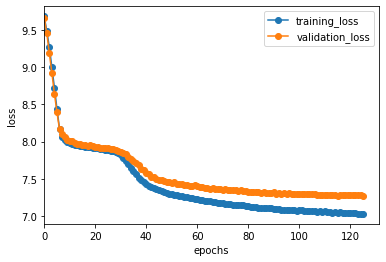

/home/ubuntu/Dataset/model/my_model10_03_17_50
/home/ubuntu/Dataset/model/my_model10_03_17_50/Epoch_116_Val_7.274.hdf5


In [77]:
# def one_shot(e_num = 3):
e_num = 3
batch_size = 32
epochs = 10000

output_size = 2

train_list,val_list,test_list = subject_split(S_cnt = S_cnt,using_num=[0,1],print_list=True)
X_train,y_train,X_val,y_val,X_test,y_test = preprocessing(train_list,val_list,test_list,is_scale=False,e_num=e_num,drop_channel=[])

input_shape = (X_train.shape[1],X_train.shape[2])

now = datetime.now()
nowDate = now.strftime('%d_%H_%M_%S')
model_name = 'my_model'+ nowDate


model,ancoder = ae_model(input_shape = input_shape)

#     model = cnn_model(input_shape=input_shape, output_size=output_size)
model.summary()

# model = multi_gpu_model(model,gpus=2)
# model.summary()
model.compile(loss=tf.keras.losses.mae, optimizer='adam')

# Validation 점수가 가장 좋은 모델만 저장합니다.
checkpoint_path = os.path.join(model_path, model_name)
os.makedirs(checkpoint_path, exist_ok=True)
model_file_path = os.path.join(checkpoint_path, 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath=model_file_path, monitor='val_loss', verbose=1, save_best_only=True)

# 10회 간 Validation 점수가 좋아지지 않으면 중지합니다.
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                          patience=5, min_lr=0.001)




print('train len : ', np.shape(X_train),np.shape(y_train))
print('val len : ', np.shape(X_val),np.shape(y_val))
print('test len : ', np.shape(X_test),np.shape(y_test))
history = model.fit(
X_train, X_train, validation_data=(X_val,X_val),
epochs=epochs, batch_size=batch_size,  shuffle=True,
callbacks=[checkpoint, early_stopping])
#     X_train, X_train, validation_data=(X_val,X_val),
#     epochs=epochs, batch_size=batch_size,  shuffle=True,
#     callbacks=[checkpoint, early_stopping,reduce_lr])    


plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

checkpoint_path = os.path.join(model_path, model_name)
print(checkpoint_path)
weigth_files = glob.glob('{}/*.hdf5'.format(checkpoint_path))
weigth_files.sort()
weigth_file = weigth_files[-1]
#     print(weigth_files)
print(weigth_file)
model.load_weights(weigth_file)


#     y_pred = model.predict(X_test)
# #     print(y_pred)
# #     print(y_test)
#     y_true,y_pred = np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1)
#     test_acc = accuracy_score(y_true,y_pred)
#     cnf_matrix = confusion_matrix(y_true, y_pred)
#     plot_confusion_matrix(cnf_matrix,['N','MCI'],title='model : {} , test_acc : {}'.format(model_name,test_acc))



In [78]:
input_shape[1]

63

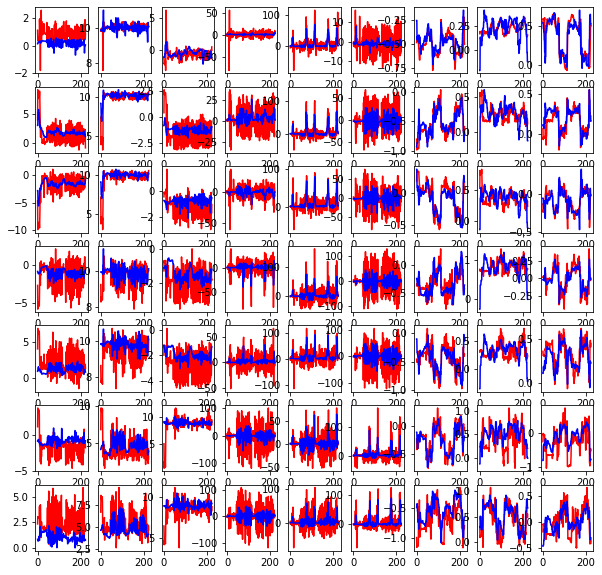

In [79]:
test_input = np.expand_dims(X_test[6],axis=0)
test_output = model.predict(test_input)

plt.figure(figsize=(10,10))
for k in range(input_shape[1]):
    plt.subplot(7,input_shape[1]//7,k+1)
    plt.plot(test_input[0,:,k],'-r')
    plt.plot(test_output[0,:,k],'-b')

In [80]:
model.layers

In [81]:
model.layers[1:-7]

In [82]:

tmp_input = model.layers[0].input
tmp_output = model.layers[9].output
flatten = Flatten()(tmp_output)

cls_res = Dropout(0.5)(cls_res)
cls_res = Dense(96,activation='relu')(flatten)
cls_res = BatchNormalization()(cls_res)
cls_res = Dropout(0.5)(cls_res)
cls_res = Dense(2,activation='softmax')(cls_res)


cls_model = Model(tmp_input, cls_res)
cls_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 63)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 224, 128)          24320     
_________________________________________________________________
batch_normalization_31 (Batc (None, 224, 128)          512       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 112, 128)          0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 112, 64)           24640     
_________________________________________________________________
batch_normalization_32 (Batc (None, 112, 64)           256       
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 56, 64)            0         
__________

In [83]:
for i in range(len(cls_model.layers[:10])):
    cls_model.layers[i].set_weights(model.layers[i].get_weights())
    cls_model.layers[i].trainable=False


In [84]:
for i in range(len(cls_model.layers)):
    print(cls_model.layers[i],cls_model.layers[i].trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fbff749a710> False
<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7fbff6ed3470> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7fbff6ed3630> False
<tensorflow.python.keras.layers.pooling.MaxPooling1D object at 0x7fbff6ed3748> False
<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7fbff6edd630> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7fbff7082d68> False
<tensorflow.python.keras.layers.pooling.MaxPooling1D object at 0x7fbff7082748> False
<tensorflow.python.keras.layers.convolutional.Conv1D object at 0x7fc009b1ff60> False
<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x7fc009b92ac8> False
<tensorflow.python.keras.layers.pooling.MaxPooling1D object at 0x7fc009b92cf8> False
<tensorflow.python.keras.layers.core.Flatten object at 0x7fbff7cd2f60> True
<tensorflow.python.keras.layers.core

In [85]:
now = datetime.now()
nowDate = now.strftime('%d_%H_%M_%S')
model_name = 'cls_model'+ nowDate

checkpoint_path = os.path.join(model_path, model_name)
os.makedirs(checkpoint_path, exist_ok=True)
model_file_path = os.path.join(checkpoint_path, 'Epoch_{epoch:03d}_Val_{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath=model_file_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [86]:
cls_model.compile(loss=tf.keras.losses.categorical_crossentropy,optimizer='adam')
history = cls_model.fit(
X_train, y_train, validation_data=(X_val,y_val),
epochs=epochs, batch_size=batch_size,  shuffle=True,
callbacks=[checkpoint, early_stopping])

Train on 874 samples, validate on 101 samples
Epoch 1/10000
768/874 [=========================>....] - ETA: 0s - loss: 1.1861
Epoch 00001: val_loss improved from inf to 0.72369, saving model to /home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_001_Val_0.724.hdf5
874/874 [==============================] - 5s 6ms/step - loss: 1.1664 - val_loss: 0.7237
Epoch 2/10000
736/874 [========================>.....] - ETA: 0s - loss: 0.9116
Epoch 00002: val_loss improved from 0.72369 to 0.70705, saving model to /home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_002_Val_0.707.hdf5
874/874 [==============================] - 0s 322us/step - loss: 0.8945 - val_loss: 0.7070
Epoch 3/10000
704/874 [=======================>......] - ETA: 0s - loss: 0.8326
Epoch 00003: val_loss improved from 0.70705 to 0.67231, saving model to /home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_003_Val_0.672.hdf5
874/874 [==============================] - 0s 331us/step - loss: 0.8359 - val_loss: 0.6723
Epoch 4/1000

Epoch 33/10000
864/874 [============================>.] - ETA: 0s - loss: 0.3445
Epoch 00033: val_loss did not improve from 0.61037
874/874 [==============================] - 0s 291us/step - loss: 0.3442 - val_loss: 0.6576
Epoch 34/10000
864/874 [============================>.] - ETA: 0s - loss: 0.3409
Epoch 00034: val_loss did not improve from 0.61037
874/874 [==============================] - 0s 284us/step - loss: 0.3410 - val_loss: 0.6694
Epoch 35/10000
864/874 [============================>.] - ETA: 0s - loss: 0.3208
Epoch 00035: val_loss did not improve from 0.61037
874/874 [==============================] - 0s 285us/step - loss: 0.3187 - val_loss: 0.6621
Epoch 36/10000
672/874 [======================>.......] - ETA: 0s - loss: 0.3209
Epoch 00036: val_loss did not improve from 0.61037
874/874 [==============================] - 0s 280us/step - loss: 0.3214 - val_loss: 0.6840
Epoch 37/10000
672/874 [======================>.......] - ETA: 0s - loss: 0.3372
Epoch 00037: val_loss did n

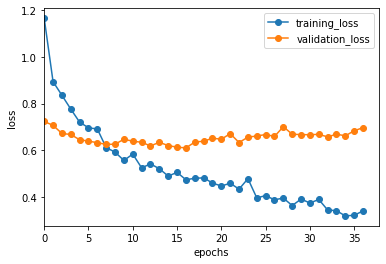

/home/ubuntu/Dataset/model/cls_model10_03_19_37
['/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_001_Val_0.724.hdf5', '/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_002_Val_0.707.hdf5', '/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_003_Val_0.672.hdf5', '/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_004_Val_0.668.hdf5', '/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_005_Val_0.645.hdf5', '/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_006_Val_0.639.hdf5', '/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_007_Val_0.633.hdf5', '/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_008_Val_0.625.hdf5', '/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_013_Val_0.619.hdf5', '/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_016_Val_0.613.hdf5', '/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_017_Val_0.610.hdf5']
/home/ubuntu/Dataset/model/cls_model10_03_19_37/Epoch_017_Val_0.610.hdf5


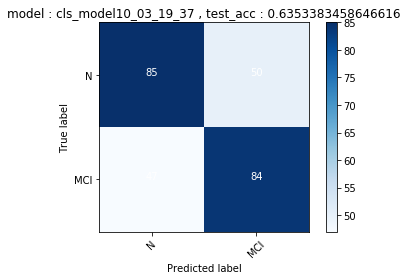

In [87]:
# Validation 점수가 가장 좋은 모델만 저장합니다.

plt.plot(history.epoch, history.history['loss'], '-o', label='training_loss')
plt.plot(history.epoch, history.history['val_loss'], '-o', label='validation_loss')
plt.legend()
plt.xlim(left=0)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

checkpoint_path = os.path.join(model_path, model_name)
print(checkpoint_path)
weigth_files = glob.glob('{}/*.hdf5'.format(checkpoint_path))
weigth_files.sort()
weigth_file = weigth_files[-1]
print(weigth_files)
print(weigth_file)
cls_model.load_weights(weigth_file)


y_pred = cls_model.predict(X_test)
#     print(y_pred)
#     print(y_test)
y_true,y_pred = np.argmax(y_test,axis=-1),np.argmax(y_pred,axis=-1)
test_acc = accuracy_score(y_true,y_pred)
cnf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cnf_matrix,['N','MCI'],title='model : {} , test_acc : {}'.format(model_name,test_acc))